## Load and Examine Data

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.gridspec as gridspec
import os

In [2]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(64,64))

In [3]:
print X.shape
print Y.shape

(1360, 64, 64, 3)
(1360, 17)


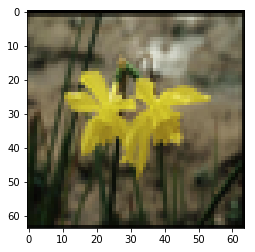

In [4]:
plt.imshow(X[30])

## GAN

In [5]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3))

    return fig



In [18]:
mb_size = 128
Z_dim = 30
image_size = 64
tf.reset_default_graph()
#X = X.reshape([-1, 12288])
def xavier_init(size):
    return tf.random_normal(shape=size, stddev=(1. / tf.sqrt(size[0] / 2.)))

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(tf.contrib.layers.flatten(x), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='X')
#X_tf = tf.convert_to_tensor(X, tf.float32)
#tf.reshape(X_tf, [-1, 2352])
#X_mb = tf.train.batch([X_ph], mb_size, enqueue_many = True)

D_W1 = tf.Variable(xavier_init([image_size * image_size * 3, 512]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[512]), name='D_b1')

D_W2 = tf.Variable(xavier_init([512, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

G_W1 = tf.Variable(xavier_init([Z_dim, 512]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[512]), name='G_b1')

G_W2 = tf.Variable(xavier_init([512, image_size * image_size * 3]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[image_size * image_size * 3]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]

G_sample = generator(Z_ph)
D_real, D_logit_real = discriminator(X_ph)
D_fake, D_logit_fake = discriminator(G_sample)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer(0.0001,beta1=0.5).minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer(0.0001,beta1=0.5).minimize(G_loss, var_list=theta_G)

def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])



In [13]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [14]:
def generate_a_flower():
    z = np.random.uniform(-1., 1., size=[1, Z_dim])
    g = sess.run(G_sample, feed_dict={Z_ph: z})
    return g.reshape(64, 64, 3)

Iter: 1
D loss: 1.574
G_loss: 0.5219
()


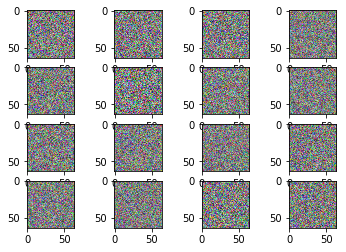

Iter: 1000
D loss: 0.7398
G_loss: 1.943
()


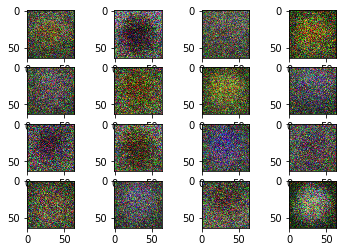

Iter: 2000
D loss: 0.6702
G_loss: 0.8222
()


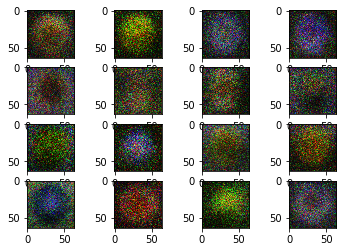

Iter: 3000
D loss: 0.7633
G_loss: 1.651
()


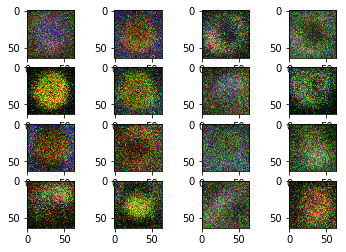

Iter: 4000
D loss: 0.8779
G_loss: 0.6874
()


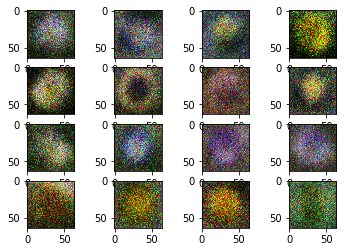

Iter: 5000
D loss: 1.854
G_loss: 0.2044
()


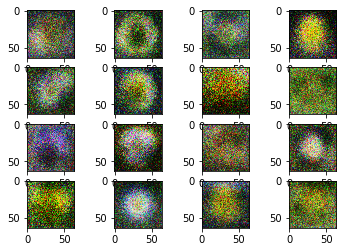

Iter: 6000
D loss: 2.135
G_loss: 0.1588
()


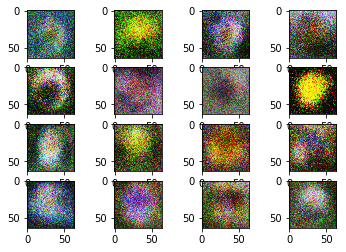

Iter: 7000
D loss: 1.415
G_loss: 2.797
()


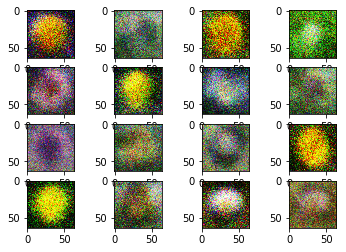

Iter: 8000
D loss: 1.202
G_loss: 2.188
()


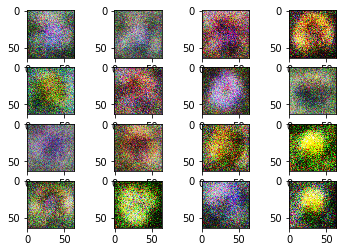

Iter: 9000
D loss: 1.758
G_loss: 3.102
()


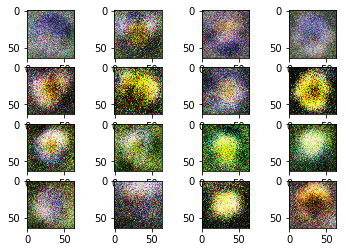

Iter: 10000
D loss: 1.611
G_loss: 2.943
()


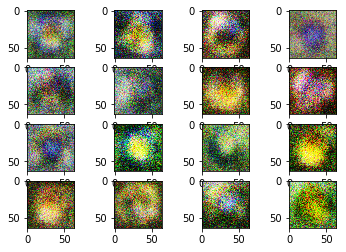

KeyboardInterrupt: 

In [21]:


global_step = tf.Variable(0, name="global_step", trainable=False)
incr_global_step_op = tf.assign(global_step, global_step+1)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

it = 0

D_loss_c = []
G_loss_c = []

batches = batch_iter(X, mb_size, 50000)

for batch in batches:

    _, D_loss_curr, _, G_loss_curr, i = sess.run([D_solver, D_loss, G_solver, G_loss, incr_global_step_op], feed_dict={X_ph: batch, Z_ph: sample_Z(batch.shape[0], Z_dim)})


    
    if i % 1000 == 0 or i==1:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        D_loss_c.append(D_loss_curr)
        G_loss_c.append(G_loss_curr)
    if i % 1000 == 0 or i==1:
        n = 4
        f, axarr = plt.subplots(n,n)
        for i in range(n):
            for j in range(n):
                axarr[i,j].imshow(generate_a_flower())
        plt.show()